# Climate Hack.AI 2022

Thank you for participating in Climate Hack.AI 2022!

Your hard work in helping to advance the state of the art in HRV satellite imagery nowcasting could be incredibly impactful in the broader fight against climate change. Within the UK electricty grid alone, your model could contribute to a reduction in carbon emissions of up to 100 kilotonnes a year.

Happy model training!

## Prerequisites

Before you begin, please ensure that you have the following packages installed.

* `xarray` for representing n-dimensional labelled arrays
* `zarr` for loading the Zarr dataset
* `gcsfs` for loading from Google Cloud Storage:  used implicitly by xarray)
* `dask` used under the hood by xarray to enable parallel processing of datasets too large to fit into RAM
* `torch` (PyTorch) for training a model
* `pytorch_msssim` to use a multi-scale structural similarity index measure-based loss function
* `matplotlib` for plotting

If you want to install them using `pip`, you can run the following command (replacing `python` with `python3` as appropriate):

```bash
$ python -m pip install numpy matplotlib zarr xarray ipykernel gcsfs fsspec dask cartopy
```

You will then need to install the appropriate PyTorch distribution for your system, the instructions for which may be found [here](https://pytorch.org/get-started/locally/).

Otherwise, if you are familar with `conda`, you may want to run the following commands to set up a `conda` environment for Climate Hack.AI:

```bash
$ conda create --name climatehack python=3.9 numpy matplotlib zarr xarray ipykernel gcsfs fsspec dask cartopy
$ conda activate climatehack
$ conda install pytorch torchvision torchaudio cpuonly -c pytorch
$ conda install -c pvlib pvlib
```

## Importing modules

In [3]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import xarray as xr
from numpy import float32
from torch.utils.data import DataLoader

from dataset import ClimateHackDataset
from loss import MS_SSIMLoss
from submission.model import Model

plt.rcParams["figure.figsize"] = (20, 12)

## Loading the dataset

The 108GB HRV ("high resolution visible") satellite imagery dataset may be loaded directly from Google Cloud Public Datasets using `xarray`, `zarr`, `gcsfs` and `dask`. Alternatively a local copy can be downloaded and loaded instead for better performance. The pixel values represent calibrated top-of-atmosphere bidirectional irradiance values mapped to the range `[0, 1023]`. Read more about the data on the [Google Cloud Platform](https://console.cloud.google.com/marketplace/product/bigquery-public-data/eumetsat-seviri-rss-hrv-uk).

### Loading the dataset from the cloud

In [4]:
SATELLITE_ZARR_PATH = "../eumetsat_seviri_hrv_uk.zarr"

dataset = xr.open_dataset(
    SATELLITE_ZARR_PATH, 
    engine="zarr",
    chunks="auto",  # Load the data as a Dask array
)

print(dataset)

<xarray.Dataset>
Dimensions:  (time: 173624, y: 891, x: 1843)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01T00:05:00 ... 2021-11-07T15:50:00
  * x        (x) float32 2.8e+04 2.7e+04 2.6e+04 ... -1.813e+06 -1.814e+06
    x_osgb   (y, x) float32 dask.array<chunksize=(891, 1843), meta=np.ndarray>
  * y        (y) float32 4.198e+06 4.199e+06 4.2e+06 ... 5.087e+06 5.088e+06
    y_osgb   (y, x) float32 dask.array<chunksize=(891, 1843), meta=np.ndarray>
Data variables:
    data     (time, y, x) int16 dask.array<chunksize=(22, 891, 1843), meta=np.ndarray>


### Loading a local copy of the dataset

Loading data from the cloud in this way can often be slow, so it is likely that you will want to download a local copy of the 104GiB dataset, at least in part.

To do this, first install `gsutil` by following [these instructions](https://cloud.google.com/storage/docs/gsutil_install).

Then, run the following command to start downloading the dataset into your current working directory:

```bash
$ gsutil -m cp -rJn gs://public-datasets-eumetsat-solar-forecasting/satellite/EUMETSAT/SEVIRI_RSS/v3/eumetsat_seviri_hrv_uk.zarr .
```

The `-n` no-clobber flag will skip previously downloaded files if the command is run multiple times, so you can download as much of the dataset as you want in stages.

Then, change the `SATELLITE_ZARR_PATH` to point to the downloaded data on your computer.

```python
SATELLITE_ZARR_PATH = "eumetsat_seviri_hrv_uk.zarr"
```

## Visualising the data

You may be curious what these 1841x891 "high resolution visible" satellite images actually look like! 

Here is an example:

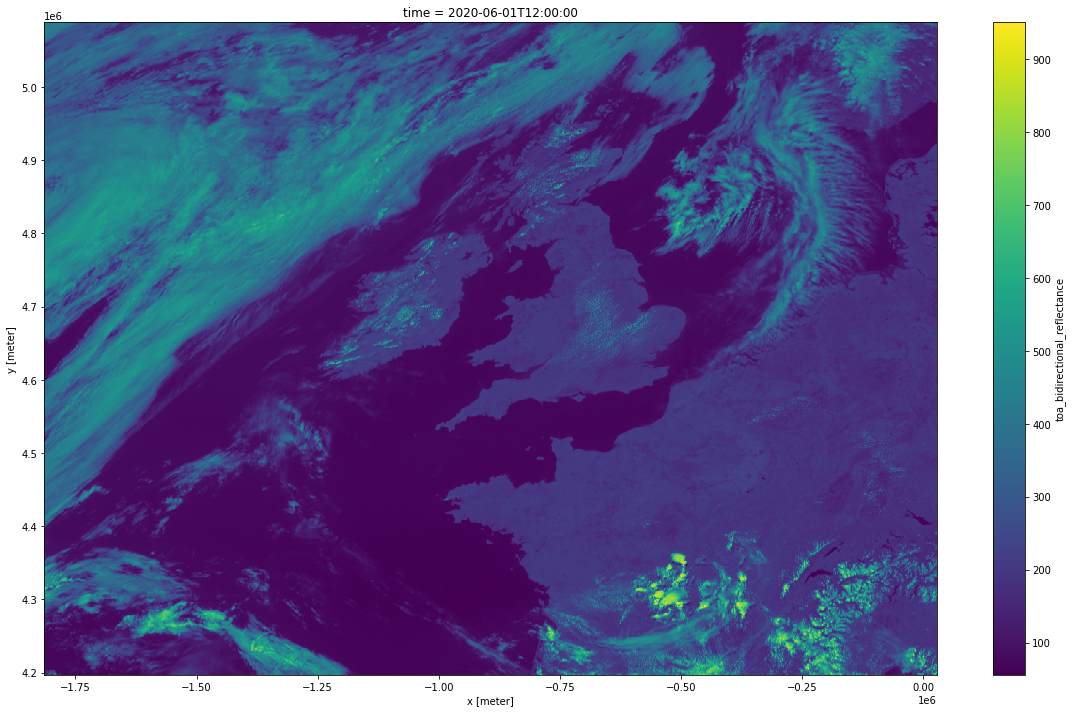

In [3]:
dataset["data"].sel(time="2020-06-01 12:00").plot()

As part of your challenge, you are given twelve 128x128 images taken five minutes apart corresponding to some region inside the 1841x891 image above, e.g.

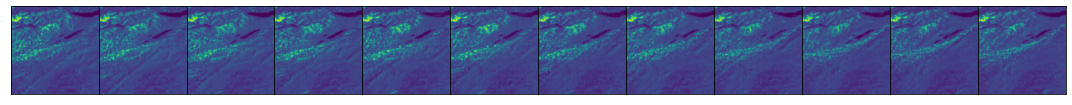

In [4]:
fig, ax = plt.subplots(1, 12, figsize=(15,3))

for i, d in enumerate(["2020-07-04 12:00", "2020-07-04 12:05", "2020-07-04 12:10", "2020-07-04 12:15", "2020-07-04 12:20", "2020-07-04 12:25", "2020-07-04 12:30", "2020-07-04 12:35", "2020-07-04 12:40", "2020-07-04 12:45", "2020-07-04 12:50", "2020-07-04 12:55"]):
    ax[i].imshow(dataset["data"].sel(time=d).isel(x=slice(128, 256), y=slice(128, 256)).to_numpy(), cmap='viridis')
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)

fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)

From these, your aim is to predict the next 24 images taken five minutes apart for the centre 64x64 region of the 128x128 area. 

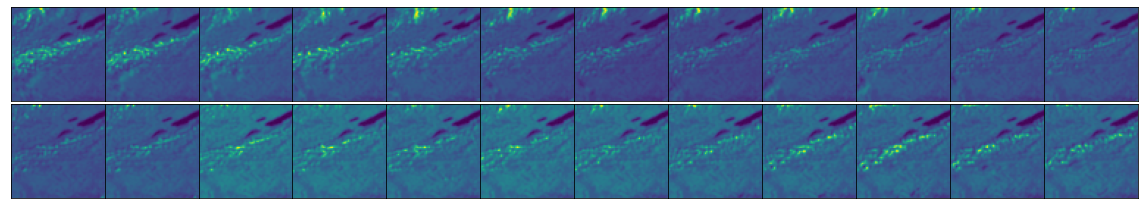

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 12, figsize=(16,3))

for i, d in enumerate(["2020-07-04 13:00", "2020-07-04 13:05", "2020-07-04 13:10", "2020-07-04 13:15", "2020-07-04 13:20", "2020-07-04 13:25", "2020-07-04 13:30", "2020-07-04 13:35", "2020-07-04 13:40", "2020-07-04 13:45", "2020-07-04 13:50", "2020-07-04 13:55"]):
    ax1[i].imshow(dataset["data"].sel(time=d).isel(x=slice(160, 224), y=slice(160, 224)).to_numpy(), cmap='viridis')
    ax1[i].get_xaxis().set_visible(False)
    ax1[i].get_yaxis().set_visible(False)

for i, d in enumerate(["2020-07-04 14:00", "2020-07-04 14:05", "2020-07-04 14:10", "2020-07-04 14:15", "2020-07-04 14:20", "2020-07-04 14:25", "2020-07-04 14:30", "2020-07-04 14:35", "2020-07-04 14:40", "2020-07-04 14:45", "2020-07-04 14:50", "2020-07-04 14:55"]):
    ax2[i].imshow(dataset["data"].sel(time=d).isel(x=slice(160, 224), y=slice(160, 224)).to_numpy(), cmap='viridis')
    ax2[i].get_xaxis().set_visible(False)
    ax2[i].get_yaxis().set_visible(False)

fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)

## Creating a model

### Defining constants

In [5]:
BATCH_SIZE = 30
EPOCHS = 20


### Instantiating the DataLoader

Since the dataset is so large, we have provided a `ClimateHackDataset` class in `dataset.py` that selects a sliding window of twelve 128x128 images (taken five minutes apart, corresponding to an hour of data) for randomly sampled areas roughly over the mainland UK to use in training.

You do not have to use this at all, if you don't want to. In fact, you are encouraged to customise it as you see fit to better suit your models! 

In [6]:
# Increase crops_per_slice if you want to crop out multiple 128x128 areas from the same sliding window.
# To only train on a subset of the dataset, either select what you want and pass it into ClimateHackDataset,
# set start_date and end_date to Python datetime objects, or set day_limit > 0 to the number of days from the start to read.

ch_dataset = ClimateHackDataset(dataset, crops_per_slice=1, day_limit=1)
ch_dataloader = DataLoader(ch_dataset, batch_size=BATCH_SIZE)

### Instantiating the model

Any models you define need to be in the `submission` folder so that they can be evaluated on DOXA. By default, they are defined in `submission/model.py`, which is where this PyTorch model is defined.

There are some huge improvements you can make to this basic model, so feel free to use this as a starting point and customise `submission/model.py` to your liking!

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Model().to(device)
optimiser = optim.Adam(model.parameters(), lr=1e-4)
criterion = MS_SSIMLoss(channels=24) # produces less blurry images than nn.MSELoss()

### Training the model

In [8]:
losses = []
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}")
    running_loss = 0
    i = 0
    count = 0
    for batch_coordinates, batch_features, batch_targets in ch_dataloader:
        optimiser.zero_grad()
        batch_predictions = model(batch_features.to(device))

        batch_loss = criterion(batch_predictions.unsqueeze(dim=2), batch_targets.unsqueeze(dim=2).to(device))
        batch_loss.backward()

        optimiser.step()

        running_loss += batch_loss.item() * batch_predictions.shape[0]
        count += batch_predictions.shape[0]
        i += 1

        print(f"Completed batch {i} of epoch {epoch + 1} with loss {batch_loss.item()} -- processed {count} image sequences ({12 * count} images)")
    
    losses.append(running_loss / count)
    print(f"Loss for epoch {epoch + 1}/{EPOCHS}: {losses[-1]}")

Epoch 1
Completed batch 1 of epoch 1 with loss 0.22517883777618408 -- processed 30 image sequences (360 images)
Completed batch 2 of epoch 1 with loss 0.5547170639038086 -- processed 32 image sequences (384 images)
Loss for epoch 1/20: 0.24577497690916061
Epoch 2
Completed batch 1 of epoch 2 with loss 0.4046124219894409 -- processed 30 image sequences (360 images)
Completed batch 2 of epoch 2 with loss 0.24935418367385864 -- processed 32 image sequences (384 images)
Loss for epoch 2/20: 0.394908782094717
Epoch 3
Completed batch 1 of epoch 3 with loss 0.25667476654052734 -- processed 30 image sequences (360 images)
Completed batch 2 of epoch 3 with loss 0.1562090516090393 -- processed 32 image sequences (384 images)
Loss for epoch 3/20: 0.25039565935730934
Epoch 4
Completed batch 1 of epoch 4 with loss 0.23142385482788086 -- processed 30 image sequences (360 images)
Completed batch 2 of epoch 4 with loss 0.09463125467300415 -- processed 32 image sequences (384 images)
Loss for epoch 4/2

## Visualising the loss

Text(0, 0.5, 'Loss')

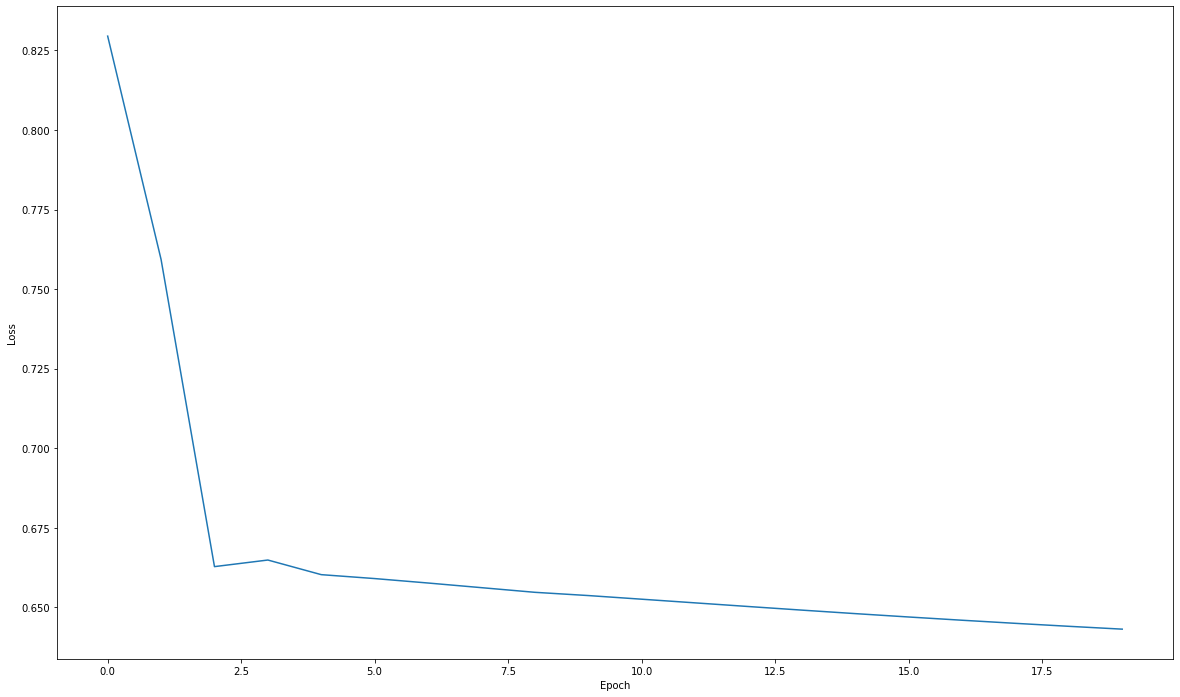

In [16]:
plt.plot(range(EPOCHS), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

## Visualising its predictions

Having trained the model, it is often useful to visualise some of its predictions to ensure it is producing a sensible output.

(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)


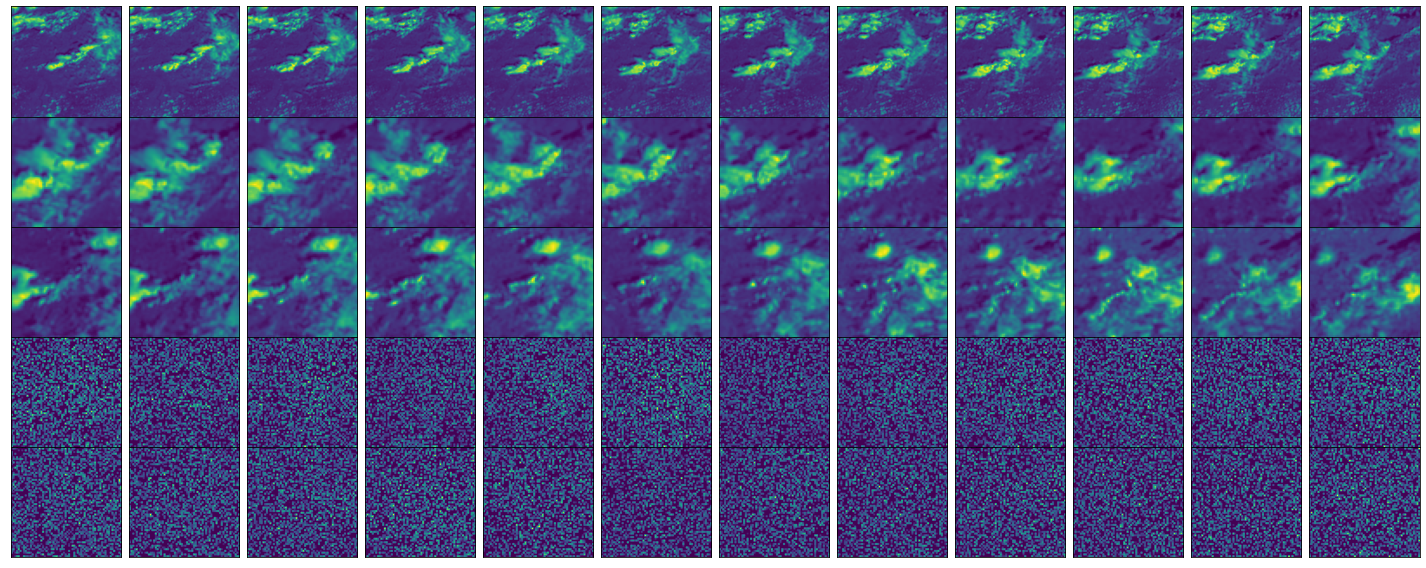

In [10]:
x = dataset["data"].sel(time=slice("2020-07-01 12:00", "2020-07-01 12:55")).isel(x=slice(128, 256), y=slice(128, 256)).to_numpy()
y = dataset["data"].sel(time=slice("2020-07-01 13:00", "2020-07-01 14:55")).isel(x=slice(160, 224), y=slice(160, 224)).to_numpy()
p = model(torch.from_numpy(x.astype(float32)).unsqueeze(dim=0)).detach().numpy()[0]

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 12, figsize=(20,8))

# plot the twelve 128x128 input images
for i, img in enumerate(x):
    ax1[i].imshow(img, cmap='viridis')
    ax1[i].get_xaxis().set_visible(False)
    ax1[i].get_yaxis().set_visible(False)

# plot twelve 64x64 true output images
for i, img in enumerate(y[:12]):
    ax2[i].imshow(img, cmap='viridis')
    ax2[i].get_xaxis().set_visible(False)
    ax2[i].get_yaxis().set_visible(False)

# plot twelve more 64x64 true output images
for i, img in enumerate(y[12:]):
    ax3[i].imshow(img, cmap='viridis')
    ax3[i].get_xaxis().set_visible(False)
    ax3[i].get_yaxis().set_visible(False)

# plot the twelve 64x64 predicted output images
for i, img in enumerate(p[:12]):
    ax4[i].imshow(img, cmap='viridis')
    ax4[i].get_xaxis().set_visible(False)
    ax4[i].get_yaxis().set_visible(False)

# plot twelve more 64x64 output images
for i, img in enumerate(p[12:]):
    ax5[i].imshow(img, cmap='viridis')
    ax5[i].get_xaxis().set_visible(False)
    ax5[i].get_yaxis().set_visible(False)

fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)

### Saving the model

Having trained the model, it can now be saved in the `submission` folder so that it may be evaluated on [DOXA](https://climatehack.ai/compete).

In [8]:
torch.save(model.state_dict(), 'submission/model.pt')

## Submitting your model to DOXA

Well done -- you made it to the end!

You are now ready to submit your model to DOXA!

If you are not already logged in, run the following command:

```bash
$ python doxa_cli.py user login
```

Finally, to submit your model, upload the entire `submission` folder into which your model was saved using the following command:

```bash
$ python doxa_cli.py agent upload climatehack ./submission
```